In [1]:
from pyquery import PyQuery as pq
import requests
from tqdm import tqdm_notebook
from tqdm import tqdm_notebook as tqdm
from pyelasticsearch import ElasticSearch
import pandas as pd
from datetime import datetime, timedelta
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from time import sleep
from matplotlib import animation
from matplotlib import gridspec
from IPython.display import HTML
import json
import numpy as np

For each token in prepared_airdrops
- Find airdrop transactions
- Create transactions graph
- Find drops and cexs
- Find ICO address, if it presents
- Find airdrop participants
- Get features for them (before and after the airdrop)
- Clusterize (do not accumulate features!)

In [2]:
client = ElasticSearch("http://localhost:9201")

In [3]:
airdrops = json.load(open("prepared_airdrops.json"))

In [6]:
NUMBER_OF_JOBS = 1000

In [ ]:
# Snovio

In [7]:
  def _count_by_object_or_string_query(client, query, index, doc_type):
    """
    Count objects in ElasticSearch by specified query

    Parameters
    ----------
    query : dict or str
        ElasticSearch query
    index : str
        ElasticSearch index
    doc_type : str
        Document type

    Returns
    -------
    int
        Number of objects in ElasticSearch
    """
    count_body = ''
    count_parameters = {}
    if type(query) is str:
      count_parameters['q'] = query
    else:
      count_body = {
        'query': query
      }
    return client.send_request('GET', [index, doc_type, '_count'], count_body, count_parameters)

  def iterate(client, index, doc_type, query, per=NUMBER_OF_JOBS):
    """
    Iterate through elasticsearch records

    Will return a chunk of records each time

    Parameters
    ----------
    index : str
        ElasticSearch index
    doc_type : str
        Document type
    query : dict or str
        ElasticSearch query
    per : int
        Max length of chunk

    Returns
    -------
    generator
        Generator that returns chunks with records by specified query
    """
    items_count = _count_by_object_or_string_query(client, query, index=index, doc_type=doc_type)['count']
    pages = round(items_count / per + 0.4999)
    scroll_id = None
    for page in tqdm(range(pages)):
      if not scroll_id:
        pagination_parameters = {'scroll': '60m', 'size': per}
        pagination_body = {}
        if type(query) is str:
          pagination_parameters['q'] = query
        else:
          pagination_body['query'] = query
        response = client.send_request('GET', [index, doc_type, '_search'], pagination_body, pagination_parameters)
        scroll_id = response['_scroll_id']
        page_items = response['hits']['hits']
      else:
        page_items = client.send_request('POST', ['_search', 'scroll'], {'scroll': '60m', 'scroll_id': scroll_id}, {})['hits']['hits']
      yield page_items

- Найти количество транзакций в эластике
- Найти узел, с которого началась раздача, для каждого из токенов, + время максимальной активности узла + узлы, которым были сделаны транзакции
- Извлечь признаки найденных узлов до времени дропа

In [6]:
def find_airdrop_address(contract, start_block):
    query = {
        "query": {
            "bool": {
                "must": [
                    {"term": {"to": contract}},
                    {"range": {"blockNumber": {"gte": start_block}}}
                ]
            }
        },
        "aggs": {
            "holders": {
                "terms": {
                    "field": "from",
                    "size": 1000
                }
            }
        }
    }
    buckets = client.search(index="ethereum-internal-transaction", doc_type="itx", query=query)["aggregations"]["holders"]["buckets"]
    return [(bucket["key"], bucket["doc_count"]) for bucket in buckets]

In [44]:
def find_participants(contract, start_block, airdrop):
    query = {
        "query": {
            "bool": {
                "must": [
                    {"term": {"from.keyword": airdrop}},
                    {"term": {"token.keyword": contract}},
                    {"range": {"block_id": {"gte": start_block}}}
                ]
            }
        },
        "aggs": {
            "holders": {
                "terms": {
                    "field": "to.keyword",
                    "size": 30000,
                    "order": {
                        "amount": "desc"
                    }
                },
                "aggs": {
                    "amount": {
                        "sum": {
                            "field": "value"
                        }
                    }
                }
            },
        }
    }
    buckets = client.search(index="ethereum-token-transaction", doc_type="tx", query=query)["aggregations"]["holders"]["buckets"]
    return [(bucket["key"], bucket["amount"]["value"]) for bucket in buckets]

In [94]:
airdrop = airdrops[3]
print(airdrop["name"])
addresses = find_airdrop_address(airdrop['contract'], airdrop["start_block"])

B2BX


In [9]:
def find_name(address):
    document = pq("https://etherscan.io/address/{}".format(address))
    return document("font[title='NameTag']").text()

In [13]:
names = {}
for address, _ in tqdm_notebook(addresses[0:600]):
    name = find_name(address)
    if name:
        names[address] = name

In [14]:
# cexs = ["Binance", "Kucoin", "Gate.io", "IDEX", "Coinbene", "EtherDelta", "Bancor", "Okex", "Kryptono", "Bibox", "Cobinhood", "Coss.io", "Huobi", "Bitfinex", "HitBTC", "Liqui.io", "0xProtocol", "Coindelta", "Yunbi", "Mercatox", "Bittrex", "Tidex"]
cex_addresses = [a for a, n in names.items()]# if not n in ["Fcoin", "Freewallet", "TokenStore"]]

In [97]:
addresses_df = pd.DataFrame()

In [99]:
addresses_df["address"] = [address for address, _ in addresses]
addresses_df["transactions"] = [number for _, number in addresses]

In [101]:
# drop_address = addresses_df[~addresses_df["address"].isin(cex_addresses)].iloc[0]["address"]
drop_address = addresses_df.iloc[0]["address"]

In [102]:
participants = find_participants(airdrop['contract'], airdrop["start_block"], drop_address)

In [103]:
participants_df = pd.DataFrame(participants, columns=["address", "amount_of_given_tokens"]).set_index("address")

# For one airdrop

In [73]:
addresses_df = participants_df
all_addresses = list(addresses_df.index)
start_block = airdrop['start_block']
TOKEN = airdrop["contract"]

In [65]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def add_features(index, doc_type, query_lambda, key):
    result = []
    for addresses in tqdm_notebook(list(chunks(all_addresses, 1000))):
        query = query_lambda(addresses, key)
        result.append(client.search(index=index, doc_type=doc_type, query=query))

    results = {b["key"]: b[key]["value"] for r in result for b in r["aggregations"]["drops"]["buckets"]}
    for address, value in tqdm_notebook(results.items()):
        addresses_df.loc[address, key] = value

In [70]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="avg_income")

In [71]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="avg_outcome")

In [74]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to.keyword": addresses}},
                    {"term": {"token.keyword": TOKEN}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to.keyword",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "sum": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-token-transaction", doc_type="tx", query_lambda=query, key="token_income")

In [75]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"query_string": {"query": "!(input:0x)"}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "cardinality": {
                            "field": "to"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="contract_transactions")

In [76]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"terms": {"to": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="exchange_transactions")

In [77]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"terms": {"from": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="out_exchange_transactions")

In [88]:
addresses_df["airdrop"] = airdrop["name"]

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [89]:
addresses_df.to_csv("addresses_stats_OMG.csv")

In [85]:
addresses_df = pd.read_csv("addresses_stats_OMG.csv").set_index("address")

In [83]:
for column in addresses_df.columns:
    addresses_df[column] = np.log(addresses_df[column].fillna(0) + 1 + 0.00001 * np.random.randn(addresses_df.shape[0]))

In [84]:
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(addresses_df)

In [86]:
addresses_df["cluster"] = clusters
addresses_df.groupby("cluster").median()

,amount_of_given_tokens,avg_income,avg_outcome,token_income,contract_transactions,exchange_transactions,out_exchange_transactions
cluster,,,,,,,
0,188.352615,1775.128204,0.500000,NaN,1.0,3.0,1.0
1,18.487270,95.789421,82.624999,9.945000,2.0,3.0,2.0
2,25.211941,169.831955,0.500000,46.351753,1.0,2.0,1.0
3,21.913651,45.499650,18.649502,1125.854410,7.0,14.0,5.0
4,80.748283,422.492130,245.574783,18.667320,3.0,5.0,2.0
5,13.186980,32.545947,13.317857,21.039921,4.0,4.0,2.0
6,603.514954,3337.689240,1429.994995,1.000000,3.0,12.5,3.0
7,27.527805,52.890928,37.994986,4.000000,8.0,15.0,10.0
8,14.920390,2.241852,64.970639,46.945002,2.0,3.0,2.0


- Найти всех участников дропа
- Убрать биржи/дропы
- Кластеризовать по признакам (до дропа)
    - Средний вход eth
    - Средний выход eth
    - Количество имеющихся токенов на счете до дропа - (количество уникальных контрактов)
    - Количество и объем транзакций ICO (пока не трогать)
    - Количество обращений к контрактам (c ненулевым input)
    - Количество исходящих транзакций на биржи 
    - Количество входящих транзакций с бирж
- Агрегировать по кластерам
- Посмотреть, какие кластеры могут влиять на качество дропа

# For each airdrop

In [90]:
def avg_income_query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

def avg_outcome_query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"range": {"blockNumber": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "avg": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

def token_income_query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to.keyword": addresses}},
                    {"term": {"token.keyword": TOKEN}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to.keyword",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "sum": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

def contract_transactions_query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"query_string": {"query": "!(input:0x)"}},
                    {"range": {"block_id": {"lte": start_block}}}
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "cardinality": {
                            "field": "to"
                        }
                    }
                }
            }
        }
    }
    return query

def exchange_transactions_query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"from": addresses}},
                    {"terms": {"to": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

def out_exchange_transactions_query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": addresses}},
                    {"terms": {"from": cex_addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "to",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "value_count": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query



In [107]:
drop_addresses

{'0x2f5e044ad4adac34c8d8df738fac7743eda1409c': '0x00b35e49de29b61fa3b0ad8d8be308543db89520',
 '0x5d51fcced3114a8bb5e90cdd0f9d682bcbcc5393': '0xd973fd302064ca47ea211f80caa22894c87f53be',
 '0x83cee9e086a77e492ee0bb93c2b0437ad6fdeccc': '0x61d40b844ea5b68c9c504fccdb05b68c2d7ae965',
 '0x9a642d6b3368ddc662ca244badf32cda716005bc': '0xea3e20c0e1e194b91f485cba126d03f8988ad25e',
 '0xbdc5bac39dbe132b1e030e898ae3830017d7d969': '0x1eeeaffe28d463dcf2c1898d19cf3871e9a17d7c',
 '0xd26114cd6ee289accf82350c8d8487fedb8a0c07': '0x862cb5b6eeaafb26ebb137e0c3c5d7728800439a',
 '0xf8e386eda857484f5a12e4b5daa9984e06e73705': '0x72002915559a0b586e8b71349f15679a9e784d22'}

In [ ]:
all_addresses_df = []
drop_addresses = {}
for airdrop in tqdm_notebook(airdrops):
    print(airdrop["name"])
    addresses = find_airdrop_address(airdrop['contract'], airdrop["start_block"])
    names = {}
    for address, _ in tqdm_notebook(addresses[0:600]):
        name = find_name(address)
        if name:
            names[address] = name
    cex_addresses = [a for a, n in names.items()]
    addresses_df = pd.DataFrame()
    addresses_df["address"] = [address for address, _ in addresses]
    addresses_df["transactions"] = [number for _, number in addresses]
    drop_address = addresses_df[~addresses_df["address"].isin(cex_addresses)].iloc[0]["address"]
    drop_addresses[airdrop["contract"]] = drop_address
#     participants = find_participants(airdrop['contract'], airdrop["start_block"], drop_address)
#     participants_df = pd.DataFrame(participants, columns=["address", "amount_of_given_tokens"]).set_index("address")
    
#     addresses_df = participants_df
#     all_addresses = list(addresses_df.index)
#     start_block = airdrop['start_block']
#     TOKEN = airdrop["contract"]
    
#     add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=avg_income_query, key="avg_income") 
#     add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=avg_outcome_query, key="avg_outcome")
#     add_features(index="ethereum-token-transaction", doc_type="tx", query_lambda=token_income_query, key="token_income")    
#     add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=contract_transactions_query, key="contract_transactions")
#     add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=exchange_transactions_query, key="exchange_transactions")    
#     add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=out_exchange_transactions_query, key="out_exchange_transactions")    
    
#     all_addresses_df.append(addresses_df)

# Prepare all the graphs

In [118]:
def prepare_name(name):
    return name.lower().replace(" ", "_")

In [109]:
def create_graph(window):
    drop_addresses = window[window["method"] == "transferFrom"].groupby("from").count()["to"].sort_values(ascending=False)
    G = nx.DiGraph()
    G.add_nodes_from(window["to"].unique())
    G.add_edges_from(set([(r["from"], r["to"]) for i, r in window.iterrows()]))
    return G

In [110]:
def reduce_components(G):
    components = sorted(nx.weakly_connected_component_subgraphs(G), key=lambda x: -len(x))
    graph = components[0]
    for component in components[1:]:
        if (len(component.nodes) > 0.5 * len(components[0].nodes)) and (len(component.nodes) > 5):
            graph = nx.compose(graph, component)
    return graph

In [111]:
def reduce_graph(graph, drop_address):
    degrees = list(sorted(dict(graph.degree).items(), key=lambda x: x[1]))
    for node, degree in tqdm_notebook(degrees):
        out_nodes = list(graph.successors(node))
        in_nodes = list(graph.predecessors(node)) 
        if not len(out_nodes):
            graph.remove_node(node)
        if (len(out_nodes) == 1) and (len(in_nodes) == 1):
            out_node = out_nodes[0]
            in_node = in_nodes[0]
            if in_node == drop_address:
                if graph.degree[out_node] == 0:
                    graph.remove_node(node)
                    graph.remove_node(out_node)
                else:
                    graph.remove_node(node)            
                    try:
                        if in_node not in graph.predecessors(out_node):
                            graph.add_edge(in_node, out_node)
                    except:
                        print("Exception!", out_node)

In [ ]:
if airdrop["contract"] not in drop_addresses:
    continue

BEFORE_BLOCK_GAP = 100000
AFTER_BLOCK_GAP = 100000
TOKEN = airdrop["contract"]

query = {
    "bool": {
        "must": [
            {"term": {"token.keyword": TOKEN}},
        ]
    }
}

transactions = []
for t in iterate(client, index="ethereum-token-transaction", doc_type="tx", query=query):
    transactions += t
transactions_df = pd.DataFrame([t["_source"] for t in transactions])

new_transactions = transactions_df[(transactions_df["block_id"] > start_block - BEFORE_BLOCK_GAP) & (transactions_df["block_id"] < start_block + AFTER_BLOCK_GAP)]

window = new_transactions.sort_values("block_id")

drop_address = drop_addresses[airdrop["contract"]]
graph = create_graph(window)
reduce_graph(graph, drop_address)

a = [{"address": n} for n in graph]
t = [{"from": a, "to": b} for a, b in tqdm_notebook(graph.edges)]
prices = airdrop["prices"]
airdrop_json = {
    "name": airdrop["name"],
    "success": airdrop["class"],
    "addresses": a,
    "transactions": t,
    "prices": prices
}
json.dump(airdrop_json, open("graph/airdrops/{}_airdrop.json".format(prepare_name(airdrop["name"])), "w"))

print(airdrop["name"])
print(len(a))

In [120]:
for airdrop in tqdm_notebook([]):
    try:
        if airdrop["contract"] not in drop_addresses:
            continue

        BEFORE_BLOCK_GAP = 100000
        AFTER_BLOCK_GAP = 100000
        TOKEN = airdrop["contract"]

        query = {
            "bool": {
                "must": [
                    {"term": {"token.keyword": TOKEN}},
                ]
            }
        }

        transactions = []
        for t in iterate(client, index="ethereum-token-transaction", doc_type="tx", query=query):
            transactions += t
        transactions_df = pd.DataFrame([t["_source"] for t in transactions])

        new_transactions = transactions_df[(transactions_df["block_id"] > start_block - BEFORE_BLOCK_GAP) & (transactions_df["block_id"] < start_block + AFTER_BLOCK_GAP)]

        window = new_transactions.sort_values("block_id")

        drop_address = drop_addresses[airdrop["contract"]]
        graph = create_graph(window)
        reduce_graph(graph, drop_address)

        a = [{"address": n} for n in graph]
        t = [{"from": a, "to": b} for a, b in tqdm_notebook(graph.edges)]
        prices = airdrop["prices"]
        airdrop_json = {
            "name": airdrop["name"],
            "success": airdrop["class"],
            "addresses": a,
            "transactions": t,
            "prices": prices
        }
        json.dump(airdrop_json, open("graph/airdrops/{}_airdrop.json".format(prepare_name(airdrop["name"])), "w"))

        print(airdrop["name"])
        print(len(a))
    except:
        print(airdrop["name"])

Agora Exclusive Airdrop
2


Qtum 
588


OmiseGo
41077


B2BX
279


Goldmint
261


Indorse


Snovio
358


TEST TRANSACTIONS

In [ ]:
TOKEN = "0xf3e014fe81267870624132ef3a646b8e83853a96"

In [9]:
query = {
    "bool": {
        "must": [
            {"term": {"to": TOKEN}},
        ]
    }
}

transactions = []
for t in iterate(client, index="ethereum-internal-transaction", doc_type="itx", query=query):
    transactions += t
transactions_df = pd.DataFrame([t["_source"] for t in transactions])

KeyboardInterrupt: 

In [ ]:
ABI = json.loads("""[
      {
        "outputs": [
          {
            "name": "",
            "type": "string"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "name",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "_spender",
            "type": "address"
          },
          {
            "name": "_value",
            "type": "uint256"
          }
        ],
        "name": "approve",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [],
        "name": "activate",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "lockPeriod1",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "totalSupply",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "_from",
            "type": "address"
          },
          {
            "name": "_to",
            "type": "address"
          },
          {
            "name": "_value",
            "type": "uint256"
          }
        ],
        "name": "transferFrom",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "address"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "founder1Address",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "decimals",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "string"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "contactInformation",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "addr",
            "type": "address"
          }
        ],
        "name": "addToTimeLockedList",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "isActivated",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "_spender",
            "type": "address"
          },
          {
            "name": "_subtractedValue",
            "type": "uint256"
          }
        ],
        "name": "decreaseApproval",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [
          {
            "name": "",
            "type": "address"
          }
        ],
        "name": "isPresaleBuyer",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "balance",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [
          {
            "name": "_owner",
            "type": "address"
          }
        ],
        "name": "balanceOf",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "icoEndTime",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "lockPeriodForBuyers",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "_address",
            "type": "address"
          },
          {
            "name": "isWhitelisted",
            "type": "bool"
          }
        ],
        "name": "editWhitelist",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "address"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "owner",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "address"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "founder2Address",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "string"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "symbol",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "icoStartTime",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [
          {
            "name": "",
            "type": "address"
          }
        ],
        "name": "whitelistedBeforeActivation",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "_to",
            "type": "address"
          },
          {
            "name": "_value",
            "type": "uint256"
          }
        ],
        "name": "transfer",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "lockPeriod2",
        "type": "function"
      },
      {
        "outputs": [],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "info",
            "type": "string"
          }
        ],
        "name": "setContactInformation",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "_spender",
            "type": "address"
          },
          {
            "name": "_addedValue",
            "type": "uint256"
          }
        ],
        "name": "increaseApproval",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "remaining",
            "type": "uint256"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [
          {
            "name": "_owner",
            "type": "address"
          },
          {
            "name": "_spender",
            "type": "address"
          }
        ],
        "name": "allowance",
        "type": "function"
      },
      {
        "outputs": [],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "newOwner",
            "type": "address"
          }
        ],
        "name": "transferOwnership",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "newSaleAddress",
            "type": "address"
          }
        ],
        "name": "setSaleAddress",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "bool"
          }
        ],
        "constant": false,
        "payable": false,
        "inputs": [
          {
            "name": "newTime",
            "type": "uint256"
          }
        ],
        "name": "setIcoEndTime",
        "type": "function"
      },
      {
        "outputs": [
          {
            "name": "",
            "type": "address"
          }
        ],
        "constant": true,
        "payable": false,
        "inputs": [],
        "name": "saleAddress",
        "type": "function"
      },
      {
        "payable": false,
        "inputs": [
          {
            "name": "_founder1Address",
            "type": "address"
          },
          {
            "name": "_founder2Address",
            "type": "address"
          },
          {
            "name": "_icoStartTime",
            "type": "uint256"
          },
          {
            "name": "_icoEndTime",
            "type": "uint256"
          }
        ],
        "type": "constructor"
      },
      {
        "inputs": [
          {
            "indexed": true,
            "name": "from",
            "type": "address"
          },
          {
            "indexed": true,
            "name": "to",
            "type": "address"
          },
          {
            "indexed": false,
            "name": "value",
            "type": "uint256"
          }
        ],
        "name": "Transfer",
        "anonymous": false,
        "type": "event"
      },
      {
        "inputs": [
          {
            "indexed": true,
            "name": "owner",
            "type": "address"
          },
          {
            "indexed": true,
            "name": "spender",
            "type": "address"
          },
          {
            "indexed": false,
            "name": "value",
            "type": "uint256"
          }
        ],
        "name": "Approval",
        "anonymous": false,
        "type": "event"
      },
      {
        "inputs": [
          {
            "indexed": true,
            "name": "previousOwner",
            "type": "address"
          },
          {
            "indexed": true,
            "name": "newOwner",
            "type": "address"
          }
        ],
        "name": "OwnershipTransferred",
        "anonymous": false,
        "type": "event"
      }
    ]""")

In [ ]:
from ethereum.abi import (
    decode_abi,
    normalize_name as normalize_abi_method_name,
    method_id as get_abi_method_id)
from ethereum.utils import encode_int, zpad, decode_hex

In [ ]:
def _decode_input(call_data, contract_abi=ABI):
  """
  Decode input data of a transaction according to a contract ABI

  Solution from https://ethereum.stackexchange.com/questions/20897/how-to-decode-input-data-from-tx-using-python3?rq=1

  Parameters
  ----------
  contract_abi : list
      List of contract methods specifications
  call_data : str
      Input of transaction in a form of 0x(4 bytes of method)(arguments),
      i.e. 0x12345678000000000000....

  Returns
  -------
  dict
      Name and parsed parameters extracted from the input
      None, if there is no such method in ABI, or there was a problem with method arguments
  """
  call_data_bin = decode_hex(call_data)
  method_signature = call_data_bin[:4]
  for description in contract_abi:
    if description.get('type') != 'function':
      continue
    method_name = normalize_abi_method_name(description['name'])
    arg_types = [item['type'] for item in description['inputs']]
    method_id = get_abi_method_id(method_name, arg_types)
    if zpad(encode_int(method_id), 4) == method_signature:
      try:
        args = decode_abi(arg_types, call_data_bin[4:])
        args = [{'type': arg_types[index], 'value': str(value)} for index, value in enumerate(args)]
      except AssertionError:
        continue
      return {'name': method_name, 'params': args}

In [ ]:
decoded_inputs = [_decode_input(i) for i in tqdm_notebook(transactions_df["input"])]

In [ ]:
transactions_df["decoded_input"] = decoded_inputs

In [142]:
transactions_df["decoded_input"].iloc[0]

{'name': 'transferFrom',
 'params': [{'type': 'address',
   'value': '0x43689d0c3b73562cdb143adbfaac93f529b5c23d'},
  {'type': 'address', 'value': '0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208'},
  {'type': 'uint256', 'value': '7770000000000000000'}]}

In [151]:
allowed_methods = ["transfer", "transferFrom"]

In [164]:
transactions_json = transactions_df.to_dict(orient='records')

In [165]:
transactions_json[0]

{'blockHash': '0xf0fd1a9b8c7b67b797784bb56f8992788b2a2794c6f85221b0f924592e25f4a8',
 'blockNumber': 5600292,
 'block_id': 5600292.0,
 'callType': 'call',
 'decoded_input': {'name': 'transferFrom',
  'params': [{'type': 'address',
    'value': '0x43689d0c3b73562cdb143adbfaac93f529b5c23d'},
   {'type': 'address', 'value': '0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208'},
   {'type': 'uint256', 'value': '7770000000000000000'}]},
 'error': 'Reverted',
 'from': '0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208',
 'gas': '0x2fc85',
 'gasPrice': nan,
 'gasUsed': nan,
 'input': '0x23b872dd00000000000000000000000043689d0c3b73562cdb143adbfaac93f529b5c23d0000000000000000000000002a0c0dbecc7e4d658f48e01e3fa353f44050c2080000000000000000000000000000000000000000000000006bd495d530c90000',
 'output': nan,
 'parent_error': nan,
 'subtraces': 0,
 'to': '0xf3e014fe81267870624132ef3a646b8e83853a96',
 'traceAddress': [0],
 'transactionHash': '0xa6f49e2e2d504cf9ae77e529d09c616be966468e989d3952239c646e51dfab5d',
 'tran

In [190]:
def restore_transaction(x):
    if (x["decoded_input"]) and (x["decoded_input"]["name"] in allowed_methods):
        return {
            "to": x["decoded_input"]["params"][0]["value"], 
            "from": x["from"], 
            "method": x["decoded_input"]["name"], 
            "value": x["decoded_input"]["params"][1]["value"],
            "block_id": x["blockNumber"]
        }

parsed_transactions = []

for transaction in tqdm_notebook(transactions_json):
    if transaction["decoded_input"] and (transaction["decoded_input"]["name"] == "transfer"):
        parsed_transactions.append(restore_transaction(transaction))

In [191]:
def restore_transaction(x):
    if (x["decoded_input"]) and (x["decoded_input"]["name"] in allowed_methods):
        return {
            "to": x["decoded_input"]["params"][1]["value"], 
            "from": x["decoded_input"]["params"][0]["value"], 
            "method": x["decoded_input"]["name"], 
            "value": x["decoded_input"]["params"][2]["value"],
            "block_id": x["blockNumber"]
        }

for transaction in tqdm_notebook(transactions_json):
    if transaction["decoded_input"] and (transaction["decoded_input"]["name"] == "transferFrom"):
        parsed_transactions.append(restore_transaction(transaction))

In [192]:
token_transactions_df = pd.DataFrame(parsed_transactions)
token_transactions_df.to_csv("vinchain.csv")

In [40]:
token_transactions_df = pd.read_csv("vinchain.csv")

In [45]:
token_transactions_df["block_range"] = token_transactions_df["block_id"].apply(lambda x: int(x / 100000))

In [42]:
token_transactions_df["value"] = token_transactions_df["value"].apply(lambda x: (int(x) / 10 ** 18))

In [46]:
transactions_per_block = token_transactions_df[token_transactions_df["value"] == 7.77].groupby("block_range").size()

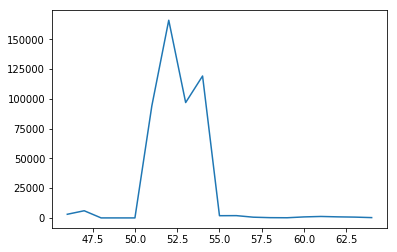

In [47]:
plt.plot(transactions_per_block.keys(), transactions_per_block.values)

In [78]:
investment_transactions = token_transactions_df[(token_transactions_df["block_range"] >= 50) & (token_transactions_df["block_range"] <= 55) & (token_transactions_df["value"] == 7.77)]

In [360]:
investment_transactions = token_transactions_df[(token_transactions_df["block_range"] >= 0) & (token_transactions_df["block_range"] <= 55) & (token_transactions_df["value"] == 7.77)]

In [361]:
drop_addresses = investment_transactions.groupby("from").nunique()["to"].sort_values(ascending=False).index[0:4]

In [362]:
drop_addresses = drop_addresses.tolist()

In [363]:
probable_investors = investment_transactions[investment_transactions["from"].isin(drop_addresses)]["to"].value_counts()

In [364]:
investors = pd.DataFrame(probable_investors)

In [365]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def add_features(index, doc_type, query_lambda, key):
    result = []
    for addresses in tqdm_notebook(list(chunks(all_addresses, 1000))):
        query = query_lambda(addresses, key)
        result.append(client.search(index=index, doc_type=doc_type, query=query))

    results = {b["key"]: b[key]["value"] for r in result for b in r["aggregations"]["drops"]["buckets"]}
    for address, value in tqdm_notebook(results.items()):
        investors.loc[address, key] = value
        
all_addresses = list(investors.index)

In [366]:
def query(addresses, key):
    query = {
        "size": 0,
        "query": {
            "bool": {
                "must": [
                    {"terms": {"to": drop_addresses}},
                    {"terms": {"from": addresses}},
                ]
            }
        },
        "aggs": {
            "drops": {
                "terms": {
                    "field": "from",
                    "size": len(addresses),
                },
                "aggs": {
                    key: {
                        "sum": {
                            "field": "value"
                        }
                    }
                }
            }
        }
    }
    return query

add_features(index="ethereum-internal-transaction", doc_type="itx", query_lambda=query, key="out_to_drops")

- Найти тех, кто закидывал деньги назад на адреса дропов
- Найти тех, кто получал не единственную транзакцию

In [346]:
probable_exchanges = token_transactions_df.groupby("from").size().sort_values(ascending=False)[0:600]

In [347]:
def find_name(address):
    document = pq("https://etherscan.io/address/{}".format(address))
    return document("font[title='NameTag']").text()

In [348]:
names = {}
for address in tqdm_notebook(probable_exchanges[0:600].index):
    name = find_name(address)
    if name:
        names[address] = name

KeyboardInterrupt: 

In [349]:
names

{}

In [319]:
cex_addresses = list(names.keys()) + ["0x8d12A197cB00D4747a1fe03395095ce2A5CC6819".lower(), "0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208"]

In [368]:
best_investors = investors[investors["to"] > 3].index.tolist()

In [369]:
def get_types(window):    
    addresses = list(set(list(window["from"].unique()) + list(window["to"].unique())))
    addresses_df = pd.DataFrame()
    addresses_df["address"] = addresses
    addresses_df = addresses_df.set_index("address")
    addresses_df["type"] = "holder"
    addresses_df.loc[best_investors, "type"] = "trader"
    addresses_df.loc[drop_addresses, "type"] = "airdrop"
    addresses_df.loc[cex_addresses, "type"] = "cex"
    return addresses_df

def get_balances(window):
    outcomes = window[["from", "value"]].groupby("from").sum()
    incomes = window[["to", "value"]].groupby("to").sum()
    balances = {}
    for address, row in incomes.iterrows():
        balances[address] = row["value"]
    for address, row in outcomes.iterrows():
        balances[address] = np.abs(balances.get(address, 0) - row["value"])
    return balances

def create_graph(window):
    drop_addresses = window[window["method"] == "transferFrom"].groupby("from").count()["to"].sort_values(ascending=False)
    G = nx.DiGraph()
    G.add_nodes_from(window["to"].unique())
    G.add_edges_from(set([(r["from"], r["to"]) for i, r in window.iterrows()]))
    return G

def reduce_components(G):
    components = sorted(nx.weakly_connected_component_subgraphs(G), key=lambda x: -len(x))
    graph = components[0]
    for component in components[1:]:
        if (len(component.nodes) > 0.5 * len(components[0].nodes)) and (len(component.nodes) > 5):
            graph = nx.compose(graph, component)
    return graph

In [370]:
START_BLOCK = 0
END_BLOCK = 5500000

In [371]:
window = token_transactions_df[(token_transactions_df["block_id"] >= START_BLOCK) & (token_transactions_df["block_id"] <= END_BLOCK)].sort_values("block_id")

In [372]:
addresses_types_df = get_types(window)
graph = create_graph(window)

In [373]:
degrees = list(sorted(dict(graph.degree).items(), key=lambda x: x[1]))
for node, degree in tqdm_notebook(degrees):
    if addresses_types_df.loc[node, "type"] != "holder":
        continue 
    out_nodes = list(graph.successors(node))
    in_nodes = list(graph.predecessors(node)) 
    if not len(out_nodes) and (len(in_nodes) == 1):
        graph.remove_node(node)
#     if (len(out_nodes) == 1) and (len(in_nodes) == 1):
#         out_node = out_nodes[0]
#         in_node = in_nodes[0]
#         if addresses_types_df.loc[in_node, "type"] == "airdrop":
#             if graph.degree[out_node] == 0:
#                 graph.remove_node(node)
#                 graph.remove_node(out_node)
#             else:
#                 graph.remove_node(node)            
#                 try:
#                     if in_node not in graph.predecessors(out_node):
#                         graph.add_edge(in_node, out_node)
#                 except:
#                     print("Exception!", out_node)

In [374]:
graph = reduce_components(graph)
len(graph.nodes)

5079

In [384]:
total_sum = token_transactions_df["value"].sum()

In [393]:
def get_value(a, b):
    return -1/np.log(token_transactions_df[(token_transactions_df["from"] == a) & (token_transactions_df["to"] == b)]["value"].sum() / total_sum)

In [391]:
list(graph.edges)[0]

('0x7171e5d4c97a3fa0d96c42e245f9bab1c7749ea4',
 '0xbd2be62ce6a4e59b21c2d34745bf14417aafc3e7')

In [392]:
get_value("0x7171e5d4c97a3fa0d96c42e245f9bab1c7749ea4", "0xbd2be62ce6a4e59b21c2d34745bf14417aafc3e7")

0.02412747121674144

In [394]:
a = [{"address": n, "type": addresses_types_df["type"].loc[n]} for n in graph]
t = [{"from": a, "to": b, "value": get_value(a, b)} for a, b in tqdm_notebook(graph.edges)]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [397]:
len(t)

10040

In [399]:
t1 = [tt for tt in t if not np.isnan(tt["value"])]

In [400]:
len(t1)

10040

In [401]:
airdrop_json = {
    "name": "VinChain",
    "image": "https://icodeadline.com/wp-content/uploads/2018/03/image1-18.png",
    "addresses": a,
    "transactions": t,
    "prices": [],
    "success": True
}

In [402]:
json.dump(airdrop_json, open("graph/airdrops/vinchain_airdrop.json", "w"))